In [87]:
from importlib import reload
if 'andor' in dir():
    reload(andor)
else:
    import andor
#
from andorCodes import AndorCodes
import time

In [88]:
try:
    andor.initialize_ctypes()
except:
    raise RuntimeError("Cannot load shared libray, not installed?")
try:
    andor.initialize_sdk()
except:
    raise RuntimeError("Cannot initialise SDK, already initialised elsewhere?")
    
print("Initialised SDK")
andor.choose_camera(0) # first
print("Set current camera to be #0 (first)")
ccd_height, ccd_width=andor.detector_size()
print(f"Size of detector is {ccd_height}x{ccd_width}")

Initialised SDK
Set current camera to be #0 (first)
Size of detector is 1024x1024


In [138]:
## detector configuration parameters
#
hbinning,vbinning=(1,1) # horizontal then vertical
region_lrbt=1,1024,1,1024#100,200,100,200
region=andor.Region(hbinning,vbinning,region_lrbt[0],region_lrbt[1],region_lrbt[2],region_lrbt[3])
exposure_time=0.05 # [s]
##
andor.set_region(region)
print(f"Binning HxV is {hbinning}x{vbinning}")
print("ROI is (L,R,B,T)={0[0]}x{0[1]},{0[2]},{0[3]}".format(region_lrbt))

andor.set_exposure(exposure_time)
print(f"Asked for exposure time is {1e3*exposure_time:.1f}ms")

times=andor.get_timing()
print(f"Therefore, exposure time is {1e3*times[0]:.1f}ms and acquisition time is {1e3*times[1]:.1f}ms")

Binning HxV is 1x1
ROI is (L,R,B,T)=1x1024,1,1024
Asked for exposure time is 50.0ms
Therefore, exposure time is 50.0ms and acquisition time is 105.7ms


In [139]:
print(f"Shutter {'is' if andor.get_shutter_info() else 'is not'} available")
ttl_high=True
shutter_mode='Open'
open_time,close_time=0,0
andor.set_shutter(shutter_mode,ttl_high,open_time,close_time)
print(f"Shutter set to TTL o/p {'high' if ttl_high else 'low'}")
print(f"Shutter mode is '{shutter_mode}'")
print(f"Shutter open/close time is {open_time}/{close_time}ms")

trigger_mode='Internal'
andor.set_trigger(trigger_mode)
print(f"Tigger mode is '{trigger_mode}'")

# No need to do this, the default it seems
acq_mode='Continuous'
andor.set_acquisition(acq_mode)
print(f"Acquisition mode is '{acq_mode}'")

read_mode='Image'
andor.set_read(read_mode)
print(f"Read mode is '{read_mode}'")

img_capacity=andor.get_size_of_circular_buffer()
print(f"Expect {times[1]*img_capacity:.2f}s before circular buffer is full")

Shutter is available
Shutter set to TTL o/p high
Shutter mode is 'Open'
Shutter open/close time is 0/0ms
Tigger mode is 'Internal'
Acquisition mode is 'Continuous'
Read mode is 'Image'
Expect 2.54s before circular buffer is full


In [143]:
try:
    andor.abort_acquisition()
except:
    print("No acquisition to abort")
andor.free_internal_memory()

True

In [154]:
print(f"Number images in SDK now={andor.get_total_number_images_acquired()}")
start_time=time.time()
## start acq.
#
andor.start_acquisition()

tlen=3 # how many seconds to wait for
import ctypes
def wait_for_acquisition():
    acquiring=True
    end_of_acqs=0
    while acquiring:
        if time.time()-start_time>tlen:
            print(f"Acquisition ending as {tlen}s passed")
            andor.abort_acquisition()
            break
#        print("Waiting for end of acquisition")
        n_imgs=andor.get_total_number_images_acquired()
        print(f"\t{time.time()-start_time:.1f}s:# images={n_imgs:3d}",end="")
        if n_imgs:
            print(andor.get_number_available_images())
        else:
            print()
        end_of_acqs+=1
        andor.wait_for_acquisition()
        if andor.last_ret_code==AndorCodes.DRV_NO_NEW_DATA:
            andor.abort_acquisition()
            print(f"Acquisition ended without data {AndorCodes.values[andor.last_ret_code]}")
            acquiring=False
        else:
            acc,kin=andor.get_acquisition_progress()
            if acc==0 and kin==0:
                print("Acquisition end")
            stat=andor.get_status()
            acquiring=(stat==AndorCodes.DRV_ACQUIRING)
    print(f"Acquisition completed, end of waits={end_of_acqs}")

wait_for_acquisition()
stat=andor.get_status()
print(f"Status is {AndorCodes.values[stat]}")
print(f"Number images in SDK now={andor.get_total_number_images_acquired()}")

Number images in SDK now=28
	0.0s:# images=  0
	0.1s:# images=  1(1, 1)
	0.3s:# images=  2(1, 2)
	0.4s:# images=  3(1, 3)
	0.5s:# images=  4(1, 4)
	0.6s:# images=  5(1, 5)
	0.7s:# images=  6(1, 6)
	0.8s:# images=  7(1, 7)
	0.9s:# images=  8(1, 8)
	1.0s:# images=  9(1, 9)
	1.1s:# images= 10(1, 10)
	1.2s:# images= 11(1, 11)
	1.3s:# images= 12(1, 12)
	1.4s:# images= 13(1, 13)
	1.5s:# images= 14(1, 14)
	1.6s:# images= 15(1, 15)
	1.7s:# images= 16(1, 16)
	1.8s:# images= 17(1, 17)
	1.9s:# images= 18(1, 18)
	2.0s:# images= 19(1, 19)
	2.2s:# images= 20(1, 20)
	2.3s:# images= 21(1, 21)
	2.4s:# images= 22(1, 22)
	2.5s:# images= 23(1, 23)
	2.6s:# images= 24(1, 24)
	2.7s:# images= 25(2, 25)
	2.8s:# images= 26(3, 26)
	2.9s:# images= 27(4, 27)
	3.0s:# images= 28(5, 28)
Acquisition ending as 3s passed
Acquisition completed, end of waits=29
Status is DRV_IDLE
Number images in SDK now=29


In [150]:
print(f"# images acquired={andor.get_total_number_images_acquired()}")
image_indices=andor.get_number_available_images()
print("# images available={1} ({0[0]}/{0[1]})".format(image_indices,image_indices[1]-image_indices[0]+1))
data,first,last=andor.get_images(image_indices[0],image_indices[1])
data=data.reshape([last-first+1]+list(region.shape))
print(f"Got the acquired data, length={data.shape}")
frame_nos=numpy.arange(image_indices[0],image_indices[1]+1)

# images acquired=28
# images available=24 (5/28)
Got the acquired data, length=(24, 1024, 1024)


Populating the interactive namespace from numpy and matplotlib


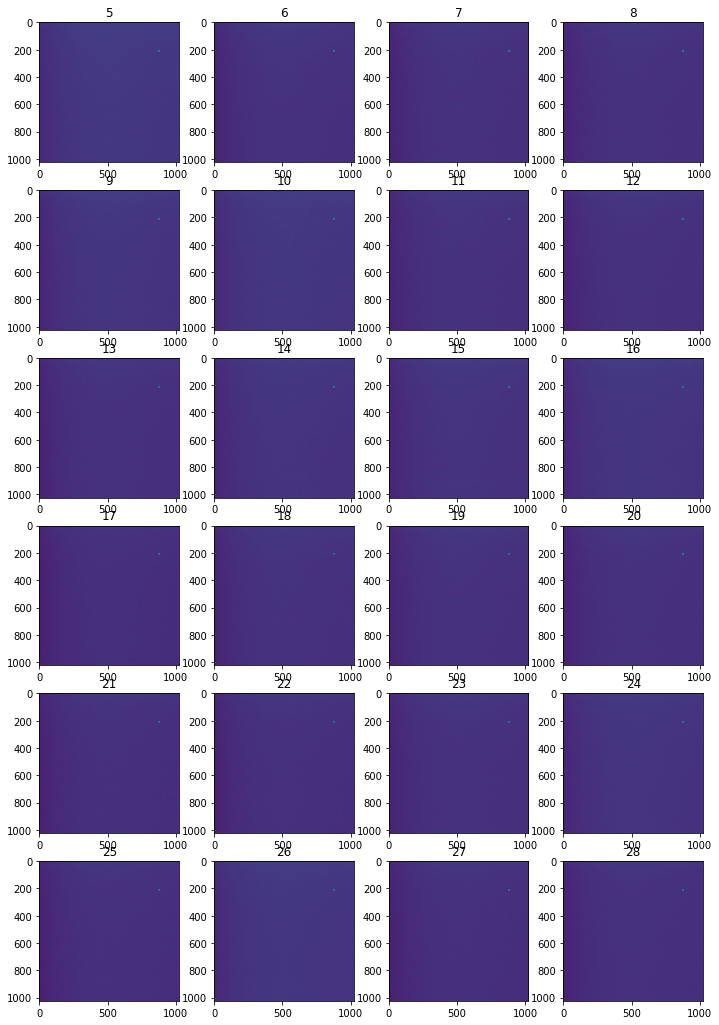

In [151]:
%pylab inline
fig1=pylab.figure(figsize=(12,(data.shape[0]//4+(1 if (data.shape[0]%4)>0 else 0))*3))
sps1=fig1.subplots(data.shape[0]//4+(1 if (data.shape[0]%4)>0 else 0),4)
if len(sps1.shape)==1:
    sps1.resize([1,sps1.shape[0]])
for i in range(data.shape[0]):
    sps1[i//4,i%4].imshow(data[i])
    sps1[i//4,i%4].set_title(f"{frame_nos[i]}")
while i<sps1.shape[0]*sps1.shape[1]-1:
    i+=1
    sps1[i//4,i%4].set_visible(False)

---

In [ ]:
status=andor.get_status()
print(f"Status is: {status}={AndorCodes.values[status]}")

---

In [63]:
andor.shutdown()

True

In [113]:
andor.checkretcode(andor.andorsdk.SetPreAmpGain)(andor.ctypes.c_int(0))

True